# Notebook for testing the SETP-identification algorithms

In [1]:
from classes import *
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import random
import ruptures as rpt

from tqdm.notebook import trange, tqdm

In [2]:
#Load the experiments
input_path = "temp/experiments/experiment_2020_9_21.p"
output_path = os.path.dirname(input_path)
experiments = pickle.load( open( input_path, "rb" ) )
print(len(experiments))

720


In [4]:
window = 4 #The size of the rolling window
margin = 2 # The margin around the TP

#Criteria
c1 = 0.15 #fraction of change relative to house price at t0
c2 = 5e9 #variance
c3 = 10 #percent

experiments = experiments[0:100]

with tqdm(total=len(experiments)) as pbar:
    for experiment in experiments:
        experiment.create_Metrics() #TODO: GIVE CONTROL OVER THE METRICS TO BE CREATED
        for M in experiment.allMetrics:
            M.create_statistics() #Create summary statistics for the metric(t)
            M.select_candidates(c1=c1,c2=c2,c3=c3,window=window,margin=margin) #Evaluate the three tipping point criteria
            M.first_SETP = M.candidates['rapid change_neg'].first_valid_index() #The first year in which a rapid change is found
        pbar.update(1)
            #M.plot_both(figsize=(15,20),exp_name=experiment.name)

### Select an interesting metric to improve the signal analysis

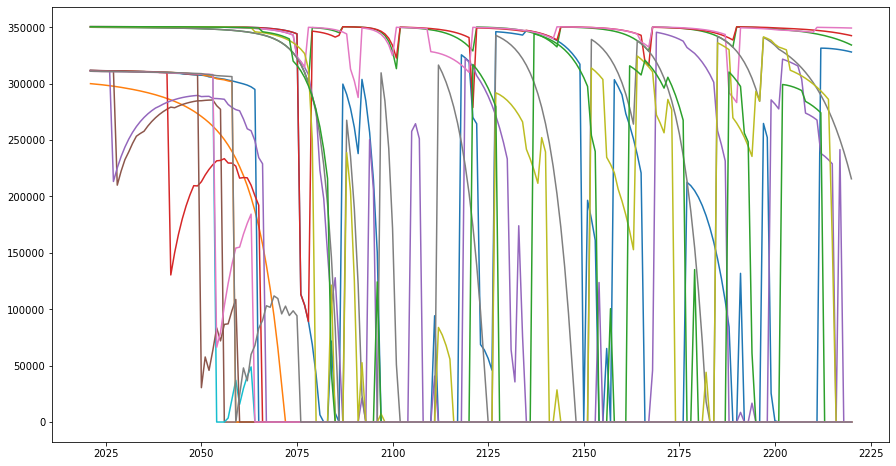

In [5]:
#Select some experiments with interesting signals
sel_experiments = sel_exp(experiments,['01','02'],'All',['R. Active','Sentiment'])

#Intereting shapes
A0_r = [1,69] #area 0 rational
A0_br = [3,5,7,9,11,15,19,45,49,59] # area 0 boundedly rational
A1_r = [1,4]
A1_br = [0,1,2,3,4,10]

M_sel = [] #List Pd Series containing interesting metrics

for i,exp in enumerate(sel_experiments):
    if i in A0_r:
        M_sel.append(exp.allMetrics[0])
    if i in A0_br:
        M_sel.append(exp.allMetrics[1])
    if i in A1_r:
        M_sel.append(exp.allMetrics[2])
    if i in A1_br:
        M_sel.append(exp.allMetrics[3])

M_sel

fig, ax = plt.subplots(figsize=(15,8))
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

for series in M_sel:
    series.raw.plot(ax=ax)

# My own original approach, with the c1-c3 as in the paper

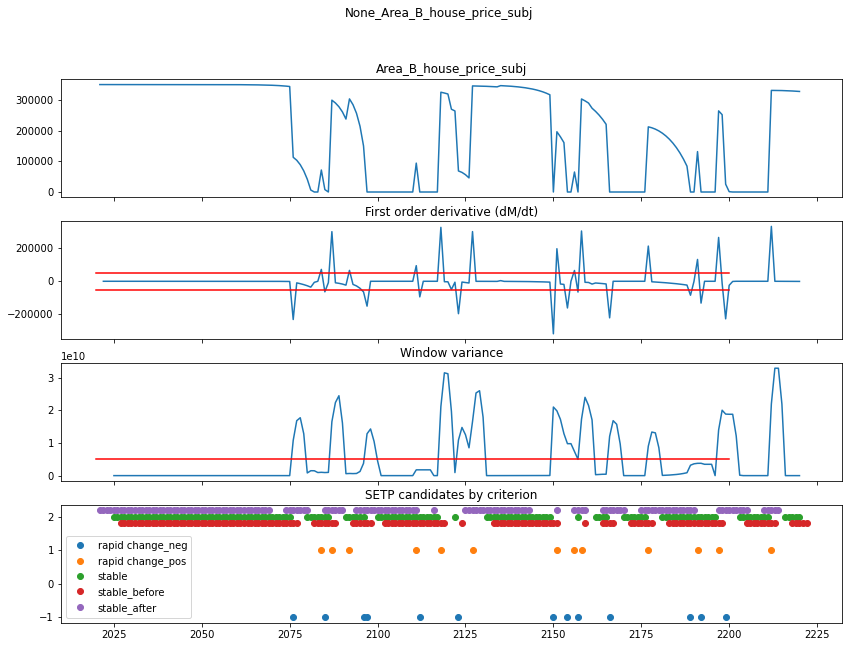

In [6]:
M = M_sel[0]
    
fig,ax = M.plot_both(figsize=(14,10),drop=['Second order derivative (d2M/dt2)','Window mean'])
ax[1].plot(list(range(2020,2201)),[0.15*-350_000]*(2201-2020),color='red',linestyle='-')
ax[1].plot(list(range(2020,2201)),[0.15*350_000]*(2201-2020),color='red',linestyle='-')
ax[2].plot(list(range(2020,2201)),[c2]*(2201-2020),color='red',linestyle='-')
ax[3].legend(loc='lower left')

### With some improvements, made the algorithm more sophisticated

TODO:
distinguish the before_after cases\
write everyting in a nice function\
look into criterion 3 (should be easy)\
test everything on more examples\
iteratively improve

In [9]:
from matplotlib import patches
from matplotlib.collections import PatchCollection

In [41]:
M.candidates['rapid change'] = pd.concat([M.candidates['rapid change_neg'].dropna(),M.candidates['rapid change_pos'].dropna()])
M.candidates['rapid change']

2021   NaN
2022   NaN
2023   NaN
2024   NaN
2025   NaN
        ..
2296   NaN
2297   NaN
2298   NaN
2299   NaN
2300   NaN
Name: rapid change, Length: 280, dtype: float64

Index(['Area_B_house_price_subj', 'First order derivative (dM/dt)',
       'Second order derivative (d2M/dt2)', 'Window mean', 'Window variance'],
      dtype='object')


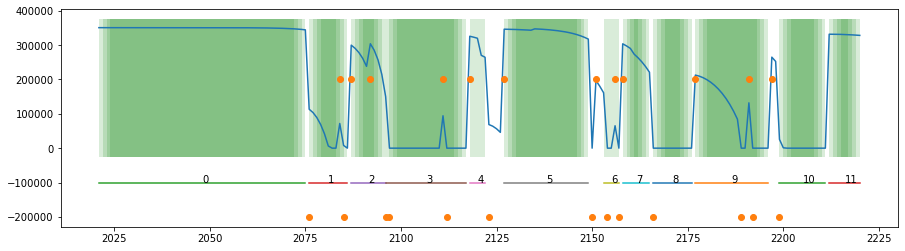

In [42]:
M = M_sel[0]

fig, ax = plt.subplots(nrows=1,figsize=(15,4))
print(M.statistics.columns)
col = M.statistics.columns[0]
ax = M.statistics[col].plot(ax=ax)


### PLOT STABLE STATES AS SHADED AREAS ###
#Windows have length 'window'
#shading starts at - window t

#Add all not-nan values as a starting point for a box
boxes_left = []
series = M.candidates['stable']
for index,value in series.items():
    if not np.isnan(value): #this is a relevant value
        boxes_left.append(index)   
boxes_left

patches_list=[]
for year in boxes_left:
    art = patches.Rectangle((year-window,- 25_000),window,400_000)
    patches_list.append(art)

pc = PatchCollection(patches_list,facecolor='green',alpha=0.15)
ax.add_collection(pc)

### PLOT TIPPING POINTS
((M.candidates['rapid change'].loc[2020:2200])*200_000).plot(style='o',ax=ax)

### Plot states
M.stable_states = find_states(series,2.0) #returns begin and end years of stable states
for i,state in enumerate(M.stable_states):
    x_values = list(range(state[0]-window,state[1]+1))
    y_value = -100_000
    ax.plot(x_values,[y_value]*len(x_values))
    ax.text(sum(x_values)/len(x_values),y_value,str(i))


In [70]:
perfect_example = [] #stable before and stable after
duplicates = [] #stable before and stable after, but this state shift was already described by other window!
same_window = [] #state before and after are in the same window (not instability at point of rapid change)
only_before = [] #stable before, but unstable after
only_after = [] #unstable before, but stable after
not_before_not_after = []

temps = [] #needs further testing

#TEST ON STATE STABILITY IF RAPID CHANGE IS ALREADY DETECTED
for index,value in M.candidates['rapid change'].items():
    if not np.isnan(value): #this is a relevant value  
        #print(index)
        before,after = find_window_around_point(index,M.stable_states,margin=2,index=True)
        #print(before,after,end="\n\n")
        if before is not None: #stable state before point
            if after is not None: #stable state after point
                temps.append((index,before,after))
            else: #stable before, but not after
                only_before.append((index,before,after))
        else: #no stable state before point
            if after is not None: #not stable before, but stable after
                only_after.append((index,before,after))
            else: 
                not_before_not_after.append((index,before,after))

for i, temp in enumerate(temps):
    if temp[1] == temp[2]:   #before and after windows is similar
        print('Same window for: {}'.format(temp))
        same_window.append(temp)
        del temps[i]

#IDENTIFY DUPLICATES        
for i,temp in enumerate(temps): #iterate over candidates of perfect example, which can still be duplicates, or 'same window'
    print('i',i, temp)
    
    #Test if this example does not already exist
    for j, temp2 in enumerate(temps):
        if not temp2 == temp:
            print('j',j,temp2)
            if temp[1] == temp2[1]:
                print('Same window for: {} and {}'.format(temp,temp2))
                duplicates.append(temps[j])
                del temps[j]
    print('\n')
    
perfect_example = temps[:]


print('perfect_examples:',perfect_example)
print('same window:',same_window)
print('duplicates:',duplicates)

perfect_example_years = [ex[0] for ex in perfect_example]
duplicates_years = [ex[0] for ex in duplicates]
only_after = [ex[0] for ex in only_after]
only_before = [ex[0] for ex in only_before]
not_before_not_after = [ex[0] for ex in not_before_not_after]

same_window = [ex[0] for ex in same_window]

print(perfect_example_years)

Same window for: (2111, 3, 3)
Same window for: (2189, 9, 9)
i 0 (2076, 0, 1)
j 1 (2085, 1, 2)
j 2 (2087, 1, 2)
j 3 (2096, 2, 3)
j 4 (2097, 2, 3)
j 5 (2151, 5, 6)
j 6 (2166, 7, 8)
j 7 (2177, 8, 9)
j 8 (2197, 9, 10)
j 9 (2212, 10, 11)


i 1 (2085, 1, 2)
j 0 (2076, 0, 1)
j 2 (2087, 1, 2)
Same window for: (2085, 1, 2) and (2087, 1, 2)
j 3 (2097, 2, 3)
j 4 (2151, 5, 6)
j 5 (2166, 7, 8)
j 6 (2177, 8, 9)
j 7 (2197, 9, 10)
j 8 (2212, 10, 11)


i 2 (2096, 2, 3)
j 0 (2076, 0, 1)
j 1 (2085, 1, 2)
j 3 (2097, 2, 3)
Same window for: (2096, 2, 3) and (2097, 2, 3)
j 4 (2166, 7, 8)
j 5 (2177, 8, 9)
j 6 (2197, 9, 10)
j 7 (2212, 10, 11)


i 3 (2151, 5, 6)
j 0 (2076, 0, 1)
j 1 (2085, 1, 2)
j 2 (2096, 2, 3)
j 4 (2166, 7, 8)
j 5 (2177, 8, 9)
j 6 (2197, 9, 10)
j 7 (2212, 10, 11)


i 4 (2166, 7, 8)
j 0 (2076, 0, 1)
j 1 (2085, 1, 2)
j 2 (2096, 2, 3)
j 3 (2151, 5, 6)
j 5 (2177, 8, 9)
j 6 (2197, 9, 10)
j 7 (2212, 10, 11)


i 5 (2177, 8, 9)
j 0 (2076, 0, 1)
j 1 (2085, 1, 2)
j 2 (2096, 2, 3)
j 3 (2151, 5, 6)
j 4 (

Index(['Area_B_house_price_subj', 'First order derivative (dM/dt)',
       'Second order derivative (d2M/dt2)', 'Window mean', 'Window variance'],
      dtype='object')


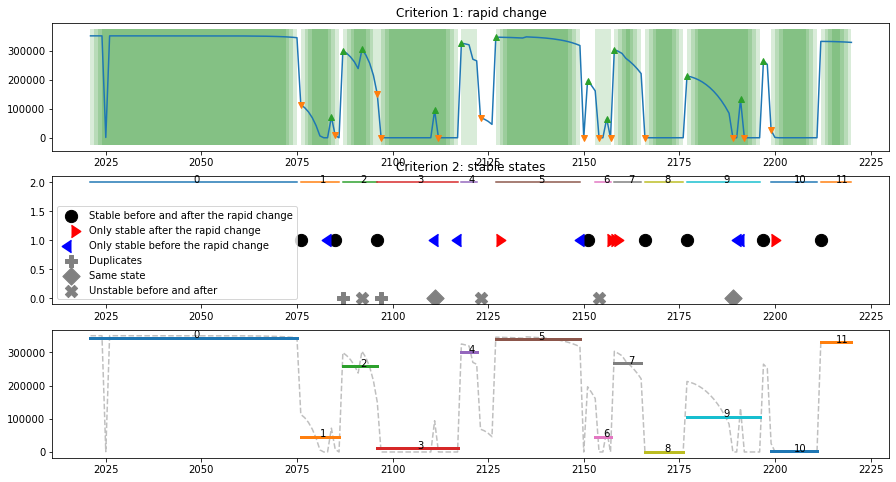

In [127]:
M = M_sel[0]

fig, ax = plt.subplots(nrows=3,figsize=(15,8))
print(M.statistics.columns)
col = M.statistics.columns[0]
M.statistics[col].plot(ax=ax[0])


### PLOT STABLE STATES AS SHADED AREAS ###
#Windows have length 'window'
#shading starts at - window t

#Add all not-nan values as a starting point for a box
boxes_left = []
series = M.candidates['stable']
for index,value in series.items():
    if not np.isnan(value): #this is a relevant value
        boxes_left.append(index)   
boxes_left

patches_list=[]
for year in boxes_left:
    art = patches.Rectangle((year-window,- 25_000),window,400_000)
    patches_list.append(art)

pc = PatchCollection(patches_list,facecolor='green',alpha=0.15)
ax[0].add_collection(pc)
ax[0].set_title('Criterion 1: rapid change')

### PLOT TIPPING POINTS
#replace the value -1 or 1 with the house price in that timestep
for index,value in M.candidates['rapid change_pos'].items():
    if not np.isnan(value):
        M.candidates['rapid change_pos'].at[index] = house_price.at[index] 

for index,value in M.candidates['rapid change_neg'].items():
    if not np.isnan(value):
        M.candidates['rapid change_neg'].at[index] = house_price.at[index] 
        
((M.candidates['rapid change_neg'].loc[2020:2200])).plot(style='v',ax=ax[0])
((M.candidates['rapid change_pos'].loc[2020:2200])).plot(style='^',ax=ax[0])

### Plot states
M.stable_states = find_states(series,window,2.0) #returns begin and end years of stable states
for i,state in enumerate(M.stable_states):
    x_values = list(range(state[0],state[1]+1))
    y_value = 2
    ax[1].plot(x_values,[y_value]*len(x_values))
    ax[1].text(sum(x_values)/len(x_values),y_value,str(i))
ax[1].set_title('Criterion 2: stable states')

    
    
### PLOT PERFECT EXAMPLES
ax[1].scatter(perfect_example_years,[1]*len(perfect_example_years),s=150,color='black',label='Stable before and after the rapid change')
ax[1].scatter(only_after,[1]*len(only_after),s=150,color='red',marker=9,label='Only stable after the rapid change') #(CARETRIGHTBASE)
ax[1].scatter(only_before,[1]*len(only_before),s=150,color='blue',marker=8,label='Only stable before the rapid change') # (CARETLEFTBASE)

ax[1].scatter(duplicates_years,[0]*len(duplicates_years),s=150,color='grey',label='Duplicates',marker="P")
ax[1].scatter(same_window,[0]*len(same_window),s=150,color='grey',label='Same state',marker="D")
ax[1].scatter(not_before_not_after,[0]*len(not_before_not_after),s=150,color='grey',label='Unstable before and after',marker="X")
ax[1].legend()


### CRITERION 3: SUBSTANTIAL DIFFERENT STATES
as_dict, as_df = mean_of_states(states,house_price)

col = M.statistics.columns[0]
M.statistics[col].plot(ax=ax[2],style='--',color='grey',alpha=0.5)

for i,state in enumerate(M.stable_states):
    x_values = list(range(state[0],state[1]+1))
    y_value = as_dict[i]
    ax[2].plot(x_values,[y_value]*len(x_values),lw=3)
    ax[2].text(sum(x_values)/len(x_values),y_value,str(i))



In [100]:
series = house_price.copy()

def mean_of_states(states,series):
    """
    For each state, calculate the mean of the values in 
    the state describe in some series
    
    Arguments:
        *states* (list of tuples) : (start_year,end_year)
        *series* (Pandas Series) : the variable of interest to take the mean over (index=year)
        
    Returns:
        *mean_of_state* (Pandas Series) : (index=year), the means over each state
    """
    mean_of_states = pd.Series(index=series.index,dtype='float64')
    asdict = {}
    for i, state in enumerate(states):
        selection = series.loc[state[0]:state[1]]
        mean = selection.mean()
        asdict[i] = mean
        for j in range(state[0],state[1]+1):
            mean_of_states.at[j] = mean
    return asdict, mean_of_states


asdict, df = mean_of_states(states,series)
asdict

{0: 342929.7391994262,
 1: 18271.75448159309,
 2: 241345.7061554906,
 3: 5234.829877033549,
 4: 264469.7134578278,
 5: 338585.57758506737,
 6: 0.0,
 7: 242958.5152607308,
 8: 0.0,
 9: 81366.67573479061,
 10: 0.0,
 11: 329430.69974016363}

In [86]:
selection = series.loc[state[0]:state[1]]
selection.mean()

329430.69974016363

In [113]:
def find_states(sample,window,findvalue):
    """
    Finds and seperate states in a series
    
    Arguments:
        *sample* (Panda Series) : index = years, values = items of interest
        *window* (int) : size of the window 
        *findvalue* (flaot/int) : the value to find in the sample
    
    Returns:
        *states* (list of tuples) : each tuple contains start and end-year of the value of interest
    
    It assumes that sample was created using a moving window, the result of which is saved at 
    the last (most right) year that is still part of the window.
    
    """
    states = [] #keep the states here, save them as a tuple (start:end)  
    start_period = None
    end_period = None
    for index,value in sample.items():
        if value == findvalue:
            if start_period is None: #no period started, make new one
                start_period = index
            end_period = index #always equate end of period to the last value
        else:
            if start_period is not None and start_period is not None:
                states.append((start_period-window,end_period)) #append a new tuple to the states
                #the above also correct for the width of the window
                start_period = None #and create a new empty period
                end_period = None
    return states

states = find_states(series,4,2.0)
states

[(2021, 2075),
 (2076, 2086),
 (2087, 2096),
 (2096, 2117),
 (2118, 2122),
 (2127, 2149),
 (2153, 2157),
 (2158, 2165),
 (2166, 2176),
 (2177, 2196),
 (2199, 2211),
 (2212, 2220)]

In [13]:
def find_window_around_point(point,windows,window_size=4,margin=2,index=True):
    """
    Determine if there are stable windows around a certain point
    
    Arguments:
        *point* (int) : the year of interest
        *windows* (list of tuple): each list items is a state, described in tuple(start,end) of window
        *window_size* (int) : indicate the length of your window
        *margin* (int) : the number of distances one should look around the point for a windows
    
    Returns:
        if index = True:
        (before,after) : indices of the windows before and after, contains None if no window could be found
        if index = False:
        return the windows themselves
    """

    before = None
    after = None
    
    #Look before the point
    for i,window in enumerate(windows):
        if point - margin >= window[0]:
            if point - margin <= window[1]:
                before = window
                if index: before = i
    
    #Look after the point
    for i,window in enumerate(windows):
        if point + margin + window_size >= window[0]:
            if point + margin + window_size <= window[1]:
                after = window
                if index: after = i
                
    return before,after

find_window_around_point(2098,states,window_size=4,margin=2,index=True)

(2, 3)

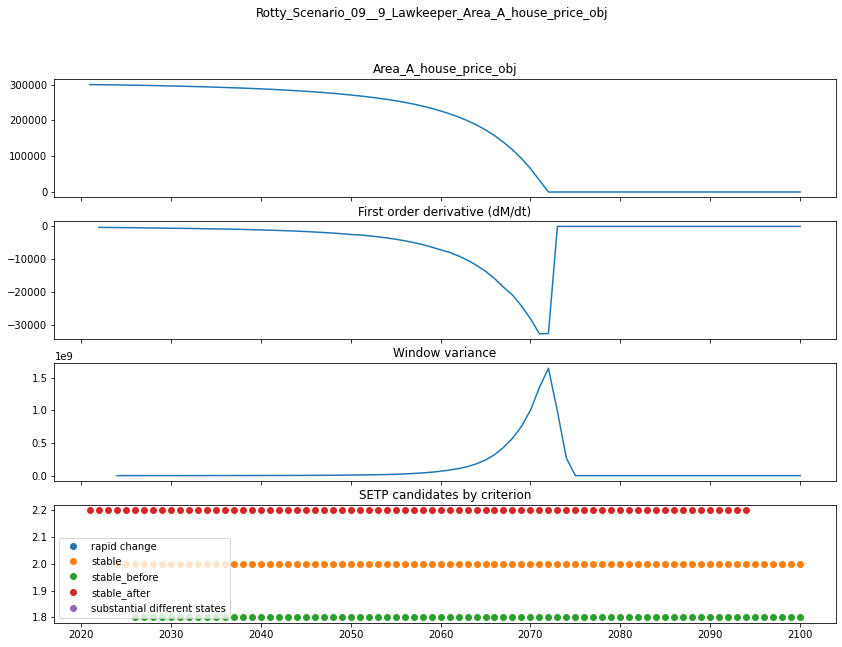

In [120]:
M = M_sel[1]

window = 4 #The size of the rolling window
margin = 2 # The margin around the TP

#Criteria
c1 = 0.15*350_000 #make different per RA (300,000 and 350,000)
c2 = 1e10 #variance
c3 = 10 #percent

M.create_statistics(domain=(2000,2100),window=window)
M.select_candidates(c1=c1,c2=c2,c3=c3,window=window,margin=margin)    
M.plot_both(figsize=(14,10),exp_name=experiment.name,drop=['Second order derivative (d2M/dt2)','Window mean'])
plt.legend(loc='lower left')

Index(['Area_A_house_price_obj', 'First order derivative (dM/dt)',
       'Second order derivative (d2M/dt2)', 'Window mean', 'Window variance'],
      dtype='object')


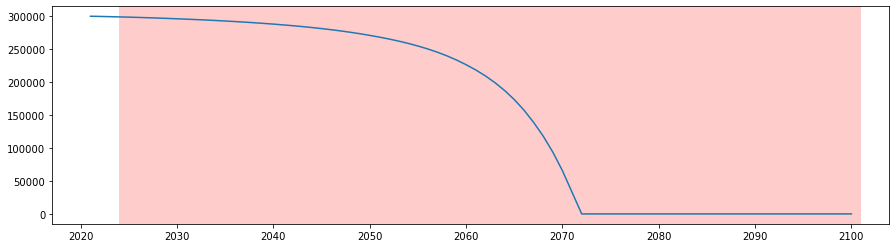

In [121]:
fig, ax = plt.subplots(nrows=1,figsize=(15,4))
print(M.statistics.columns)
col = M.statistics.columns[0]
ax = M.statistics[col].plot(ax=ax)


patches = []
boxes_left = []
series = M.candidates['stable']
for index,value in series.items():
    if not np.isnan(value): #this is a relevant value
        boxes_left.append(index)   
boxes_left

for year in boxes_left:
    art = mpatches.Rectangle((year,- 25_000),1,400_000)
    patches.append(art)

pc = PatchCollection(patches,facecolor='red',alpha=0.2)
ax.add_collection(pc)

In [16]:
#Determine if this signal has a tipping point
M.candidates['rapid change'].loc[2070:2080]
M.first_SETP = M.candidates['rapid change'].first_valid_index() #The first year in which a rapid change is found

### RUPTURES - Pruned Exact Linear Time

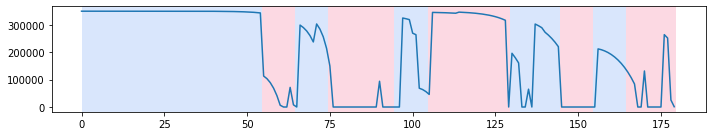

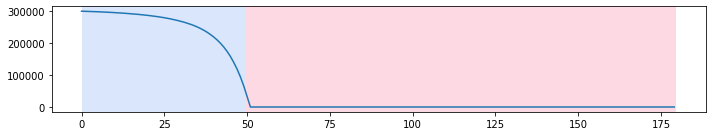

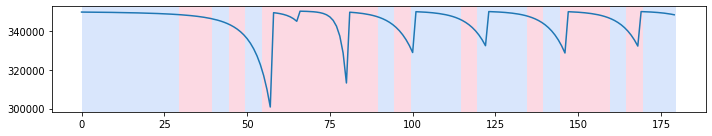

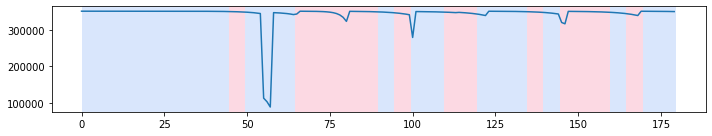

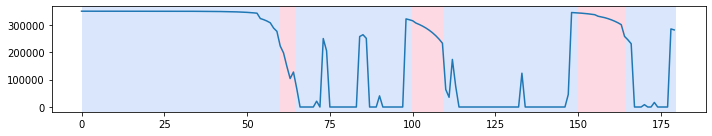

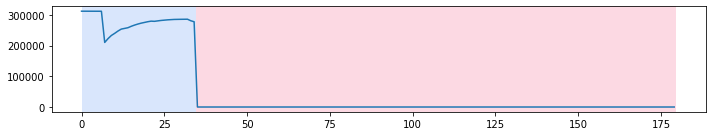

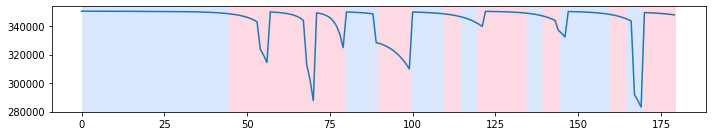

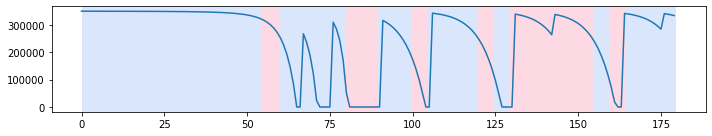

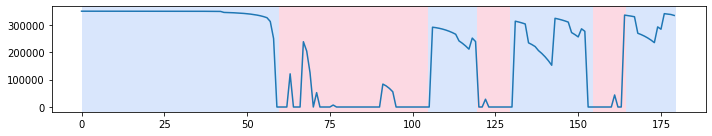

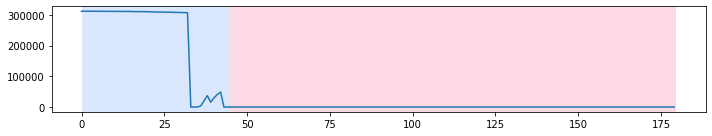

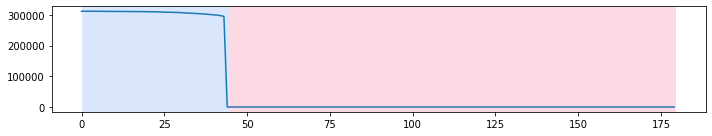

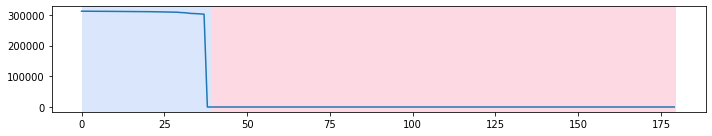

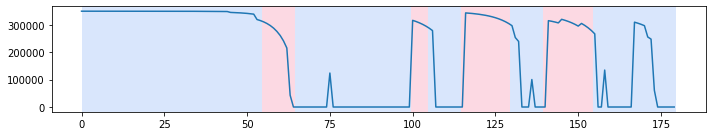

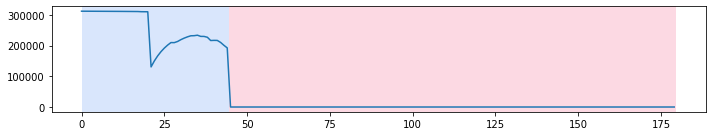

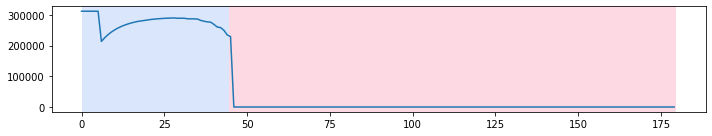

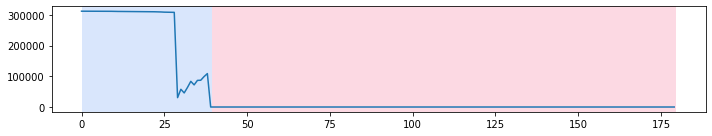

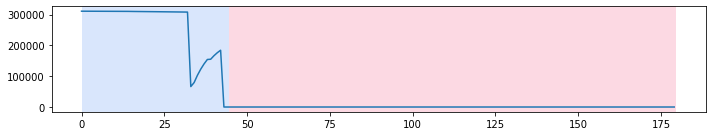

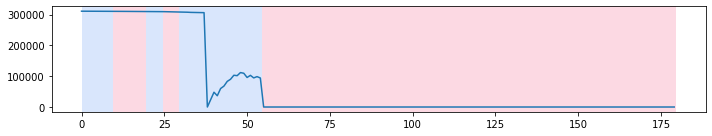

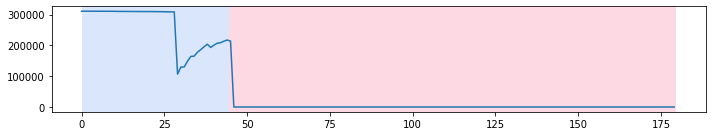

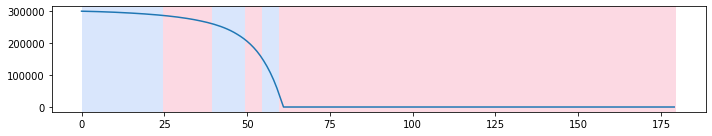

In [64]:
for series in M_sel:
    data
    #RUPTURES PACKAGE
    
    #PELT ANALYSIS Pruned Exact Linear Time
    #Signal
    signal = series.raw[0:180].values

    #Detection
    model = "rbf" # l1, l2, rbf
    min_size = 1 #minimum segement lenghts (years?)
    #jump = 80 #how big should a jump be at least (relates to t-axis???)
    pen = 2 #penalty for overfitting
    algo = rpt.Pelt(model=model,min_size=min_size).fit(signal)
    result = algo.predict(pen=pen)

    #Display
    rpt.display(signal, result)

### Binary change point detection
Documentation: https://github.com/deepcharles/ruptures/blob/master/ruptures/detection/binseg.py

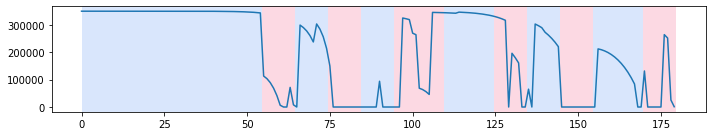

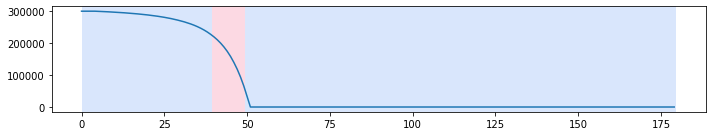

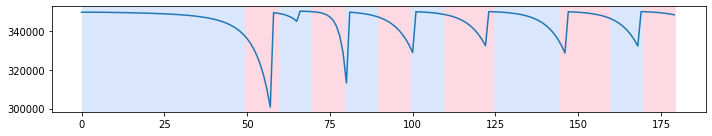

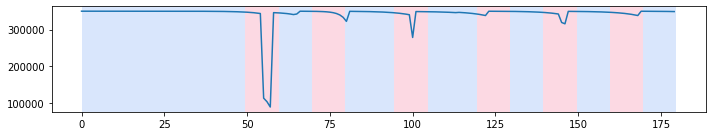

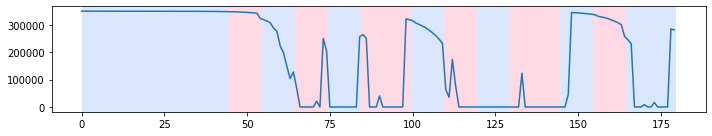

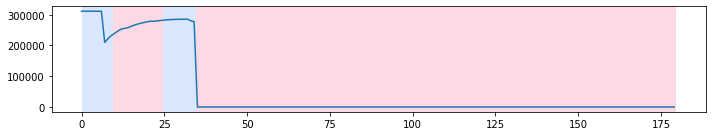

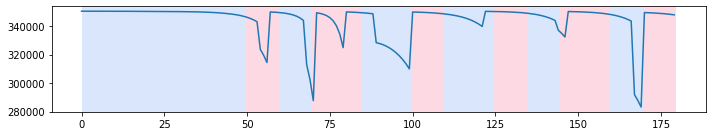

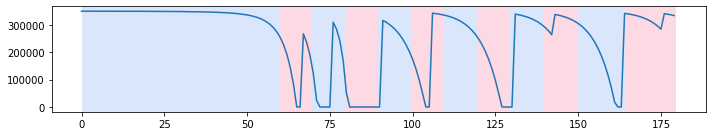

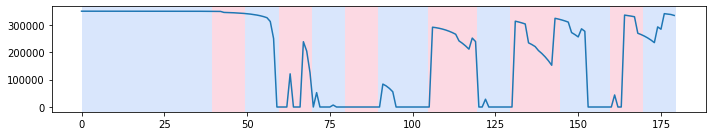

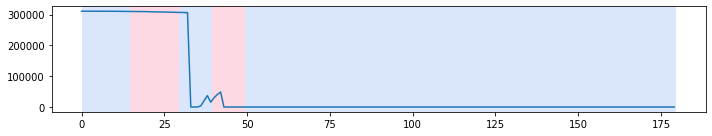

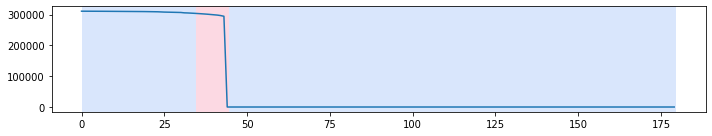

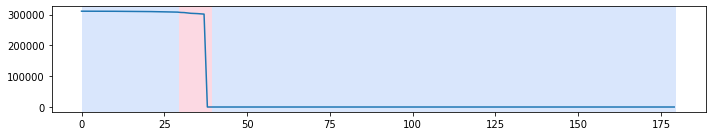

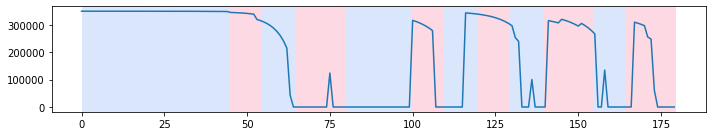

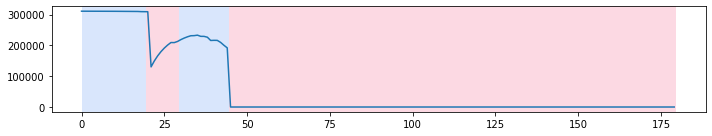

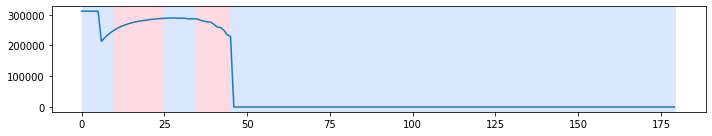

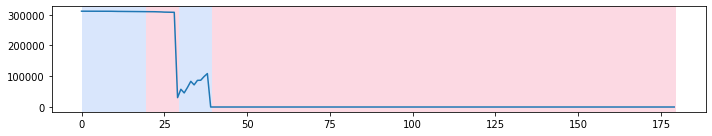

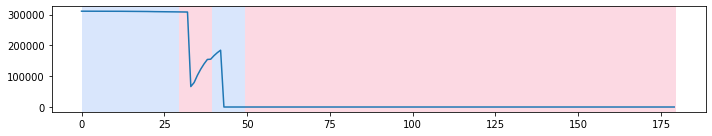

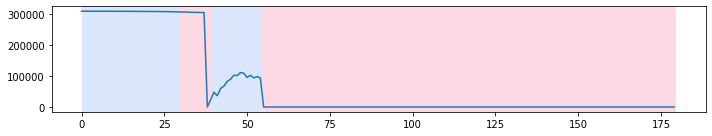

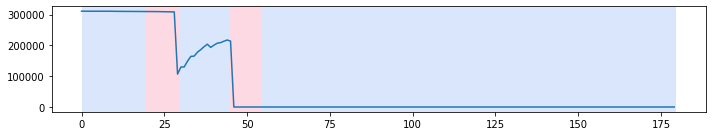

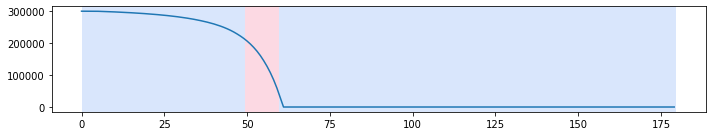

In [84]:
for series in M_sel:
    data
    #RUPTURES PACKAGE
    
    #PELT ANALYSIS
    #Signal
    signal = series.raw[0:180].values

    #Detection
    model = "ar"  # "l1", "rbf", "linear", "normal", "ar"
    pen = 100000 #penalty for overfitting
    min_size=2
    #n_bkps = 3 #number of breakpoints to find before stopping.
    algo = rpt.Binseg(model=model,min_size=min_size).fit(signal)
    result = algo.predict(pen=pen) #n_bkps=n_bkps,

    #Display
    rpt.display(signal, result)

In [7]:
rand = random.choice(sel_experiments)
rand.allMetrics[1].plot_both(figsize=(18,20),exp_name=experiment.name)

NameError: name 'random' is not defined

In [5]:
M = experiment.allMetrics[1]
M

Area_A_house_price_subj

D:\Python\Urban-SETP\classes.py:841: RuntimeWarning: divide by zero encountered in double_scalars
  perc = 100*(avg_a-avg_b)/avg_a


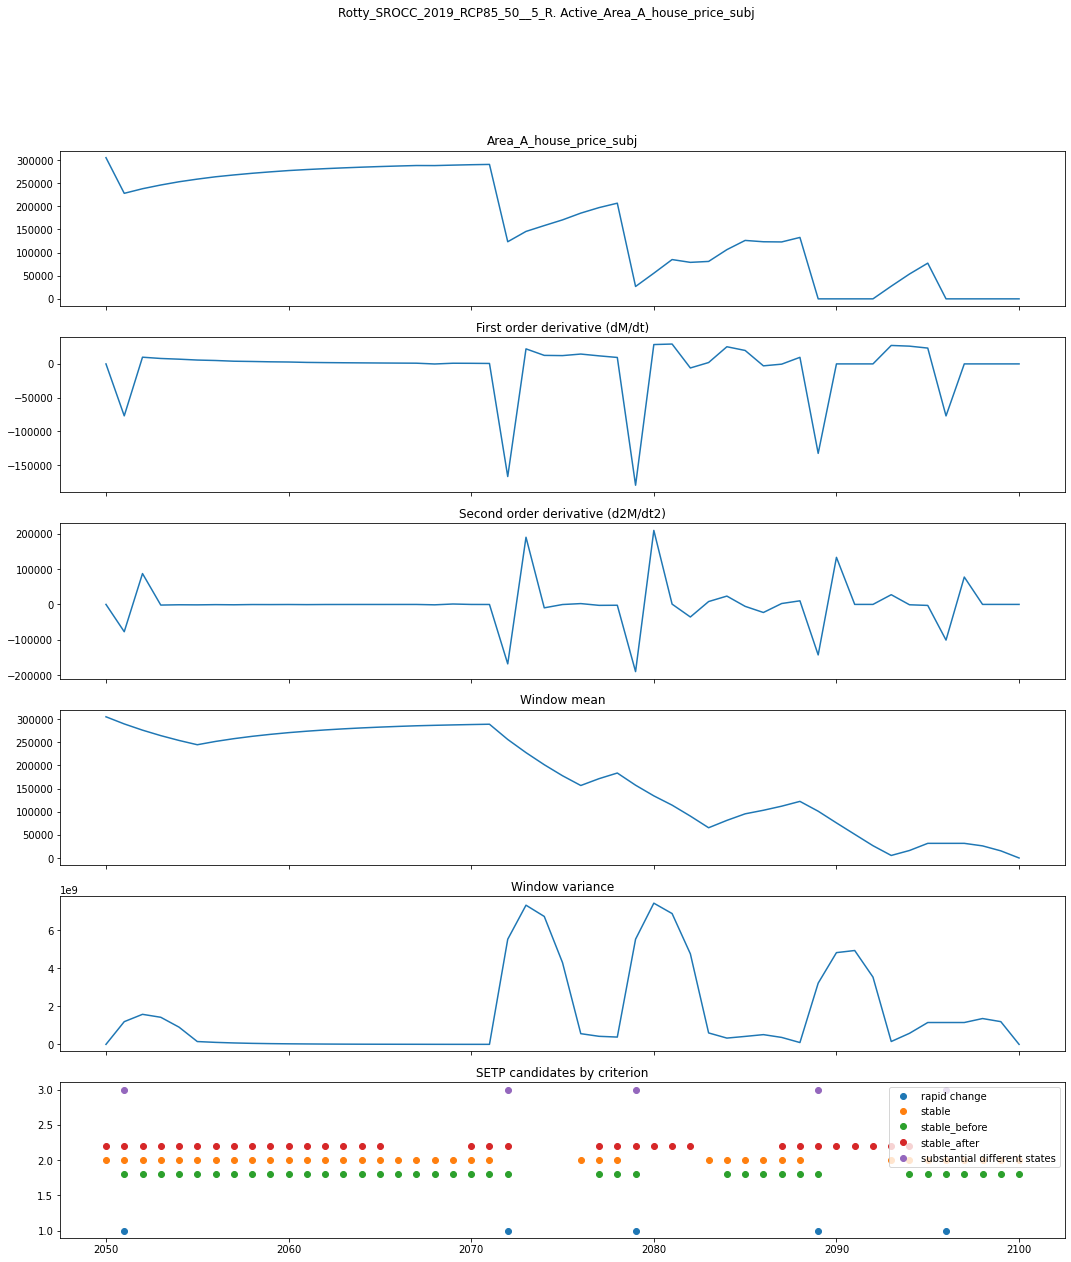

In [8]:
window = 5 #The size of the rolling window
margin = 1 # The margin around the TP
experiment.create_Metrics()
M.create_statistics(domain=(2050,2100),window=window)
M.select_candidates(window=window,margin=margin)    
M.plot_both(figsize=(18,20),exp_name=experiment.name)

### Experiment with K-means

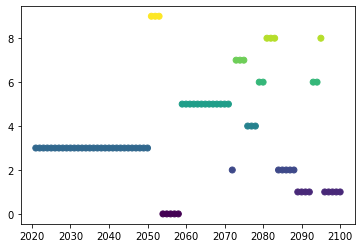

In [44]:
from sklearn.cluster import KMeans
import numpy as np
#K means Clustering 
domain = (2020,2100)

def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

series = M.raw.loc[domain[0]:domain[1]]
data = np.array(series)
data = data.reshape(-1,1)
clust_label, cent = doKmeans(data,nclust=10)
plt.scatter(series.index,clust_label,c=clust_label)